In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
import time

In [5]:
X_train, X_val, y_train, y_val = mnist_prep()

In [6]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import six
from six.moves import zip  
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.python.keras.optimizers import Optimizer

from tensorflow.python.distribute import distribution_strategy_context
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizer_v2 import adadelta as adadelta_v2
from tensorflow.python.keras.optimizer_v2 import adagrad as adagrad_v2
from tensorflow.python.keras.optimizer_v2 import adam as adam_v2
from tensorflow.python.keras.optimizer_v2 import adamax as adamax_v2
from tensorflow.python.keras.optimizer_v2 import ftrl
from tensorflow.python.keras.optimizer_v2 import gradient_descent as gradient_descent_v2
from tensorflow.python.keras.optimizer_v2 import nadam as nadam_v2
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.keras.optimizer_v2 import rmsprop as rmsprop_v2
from tensorflow.python.keras.utils.generic_utils import deserialize_keras_object
from tensorflow.python.keras.utils.generic_utils import serialize_keras_object
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import optimizer as tf_optimizer_module
from tensorflow.python.training import training_util
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.util.tf_export import keras_export

In [22]:
class SGD_test(Optimizer):
  """Stochastic gradient descent optimizer.

  Includes support for momentum,
  learning rate decay, and Nesterov momentum.

  Arguments:
      lr: float >= 0. Learning rate.
      momentum: float >= 0. Parameter that accelerates SGD in the relevant
        direction and dampens oscillations.
      decay: float >= 0. Learning rate decay over each update.
      nesterov: boolean. Whether to apply Nesterov momentum.
  """

  def __init__(self, lr=0.01, momentum=0., decay=0., nesterov=False, **kwargs):
    super(SGD_test, self).__init__(**kwargs) # für alle Optimizer gleich, SGD vom Namen der Klasse
    with K.name_scope(self.__class__.__name__): # Prefix self.__class__.__name__
      self.iterations = K.variable(0, dtype='int64', name='iterations')
      self.lr = K.variable(lr, name='lr')
      self.momentum = K.variable(momentum, name='momentum')
      self.decay = K.variable(decay, name='decay')
    self.initial_decay = decay
    self.nesterov = nesterov # hier werden nur lauter Attribute definiert

  def _create_all_weights(self, params): # Gewichte mit der richtigen Shape; wird erst aufgerufen, wenn model.fit ausgeführt wird
    shapes = [K.int_shape(p) for p in params]
    moments = [K.zeros(shape) for shape in shapes]
    self.weights = [self.iterations] + moments
    #print(self.weights)
    return moments

  def get_updates(self, loss, params): # wird erst aufgerufen, wenn model.fit ausgeführt wird
    grads = self.get_gradients(loss, params)
    #print(grads[1][127])
    self.updates = [state_ops.assign_add(self.iterations, 1)] # das immer
    #print(self.iterations)
    #print(self.updates)

    lr = self.lr
    if self.initial_decay > 0:
      lr = lr * (  # pylint: disable=g-no-augmented-assignment
          1. /
          (1. +
           self.decay * math_ops.cast(self.iterations, K.dtype(self.decay))))
    # momentum
    moments = self._create_all_weights(params)
    #print(moments)
    for p, g, m in zip(params, grads, moments):
    
      v = self.momentum * m - lr * g  # velocity    # Gradient Descent Updates
      #print(v)  
      self.updates.append(state_ops.assign(m, v))  # das immer

      if self.nesterov:
        new_p = p + self.momentum * v - lr * g
      else:
        new_p = p + v
       
      #print(new_p)
      #print(p)
      #print(self.iterations)
      #print(self.updates)

      # Apply constraints.
      if getattr(p, 'constraint', None) is not None:
        new_p = p.constraint(new_p)
        
      self.updates.append(state_ops.assign(p, new_p))    # das immer
    return self.updates

  def get_config(self):      # das immer auf diese Art; print wird nirgends angezeigt
    config = {
        'lr': float(K.get_value(self.lr)),
        'momentum': float(K.get_value(self.momentum)),
        'decay': float(K.get_value(self.decay)),
        'nesterov': self.nesterov
    }
    # print(config)
    base_config = super(SGD_test, self).get_config()     # das immer
    return dict(list(base_config.items()) + list(config.items()))  # das immer

In [27]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])

In [28]:
model = nn_model_compile(model,
                        optimizer = SGD_test())

In [30]:
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 10,
                     epochs = 5)
end_time = time.time()

Train on 1000 samples, validate on 500 samples
Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
Epoch 1/5
...Training: start of batch 0; got log keys: ['batch', 'size']
...Training: end of batch 0; got log keys: ['batch', 'size', 'loss', 'accuracy']
  10/1000 [..............................] - ETA: 0s - loss: 2.3373 - accuracy: 0.0000e+00...Training: start of batch 1; got log keys: ['batch', 'size']
...Training: end of batch 1; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 2; got log keys: ['batch', 'size']
...Training: end of batch 2; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 3; got log keys: ['batch', 'size']
...Training: end of batch 3; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 4; got log keys: ['batch', 'size']
...Training: end of batch 4; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 5; got log keys: ['batch'

 690/1000 [===================>..........] - ETA: 0s - loss: 2.1784 - accuracy: 0.2406...Training: start of batch 69; got log keys: ['batch', 'size']
...Training: end of batch 69; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 70; got log keys: ['batch', 'size']
...Training: end of batch 70; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 71; got log keys: ['batch', 'size']
...Training: end of batch 71; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 72; got log keys: ['batch', 'size']
...Training: end of batch 72; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 73; got log keys: ['batch', 'size']
...Training: end of batch 73; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 74; got log keys: ['batch', 'size']
...Training: end of batch 74; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 75; got lo

...Evaluating: end of batch 42; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 43; got log keys: ['batch', 'size']
...Evaluating: end of batch 43; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 44; got log keys: ['batch', 'size']
...Evaluating: end of batch 44; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 45; got log keys: ['batch', 'size']
...Evaluating: end of batch 45; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 46; got log keys: ['batch', 'size']
...Evaluating: end of batch 46; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 47; got log keys: ['batch', 'size']
...Evaluating: end of batch 47; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 48; got log keys: ['batch', 'size']
...Evaluating: end of batch 48; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: s

 480/1000 [=============>................] - ETA: 0s - loss: 1.6332 - accuracy: 0.5042...Training: start of batch 48; got log keys: ['batch', 'size']
...Training: end of batch 48; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 49; got log keys: ['batch', 'size']
...Training: end of batch 49; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 50; got log keys: ['batch', 'size']
...Training: end of batch 50; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 51; got log keys: ['batch', 'size']
...Training: end of batch 51; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 52; got log keys: ['batch', 'size']
...Training: end of batch 52; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 53; got log keys: ['batch', 'size']
...Training: end of batch 53; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 54; got lo

...Evaluating: start of batch 7; got log keys: ['batch', 'size']
...Evaluating: end of batch 7; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 8; got log keys: ['batch', 'size']
...Evaluating: end of batch 8; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 9; got log keys: ['batch', 'size']
...Evaluating: end of batch 9; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 10; got log keys: ['batch', 'size']
...Evaluating: end of batch 10; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 11; got log keys: ['batch', 'size']
...Evaluating: end of batch 11; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 12; got log keys: ['batch', 'size']
...Evaluating: end of batch 12; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 13; got log keys: ['batch', 'size']
...Evaluating: end of batch 13; got log 

...Training: end of batch 15; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 16; got log keys: ['batch', 'size']
...Training: end of batch 16; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 17; got log keys: ['batch', 'size']
...Training: end of batch 17; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 18; got log keys: ['batch', 'size']
...Training: end of batch 18; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 19; got log keys: ['batch', 'size']
...Training: end of batch 19; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 20; got log keys: ['batch', 'size']
...Training: end of batch 20; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 21; got log keys: ['batch', 'size']
...Training: end of batch 21; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 22; got log ke

...Training: end of batch 71; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 72; got log keys: ['batch', 'size']
...Training: end of batch 72; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 73; got log keys: ['batch', 'size']
...Training: end of batch 73; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 74; got log keys: ['batch', 'size']
...Training: end of batch 74; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 75; got log keys: ['batch', 'size']
...Training: end of batch 75; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 76; got log keys: ['batch', 'size']
...Training: end of batch 76; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 77; got log keys: ['batch', 'size']
...Training: end of batch 77; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 78; got log ke

...Evaluating: end of batch 40; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 41; got log keys: ['batch', 'size']
...Evaluating: end of batch 41; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 42; got log keys: ['batch', 'size']
...Evaluating: end of batch 42; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 43; got log keys: ['batch', 'size']
...Evaluating: end of batch 43; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 44; got log keys: ['batch', 'size']
...Evaluating: end of batch 44; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 45; got log keys: ['batch', 'size']
...Evaluating: end of batch 45; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 46; got log keys: ['batch', 'size']
...Evaluating: end of batch 46; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: s

...Training: start of batch 46; got log keys: ['batch', 'size']
...Training: end of batch 46; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 47; got log keys: ['batch', 'size']
...Training: end of batch 47; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 48; got log keys: ['batch', 'size']
...Training: end of batch 48; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 49; got log keys: ['batch', 'size']
...Training: end of batch 49; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 50; got log keys: ['batch', 'size']
...Training: end of batch 50; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 51; got log keys: ['batch', 'size']
...Training: end of batch 51; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 52; got log keys: ['batch', 'size']
...Training: end of batch 52; got log keys: ['batch', 'size'

...Evaluating: end of batch 5; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 6; got log keys: ['batch', 'size']
...Evaluating: end of batch 6; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 7; got log keys: ['batch', 'size']
...Evaluating: end of batch 7; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 8; got log keys: ['batch', 'size']
...Evaluating: end of batch 8; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 9; got log keys: ['batch', 'size']
...Evaluating: end of batch 9; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 10; got log keys: ['batch', 'size']
...Evaluating: end of batch 10; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 11; got log keys: ['batch', 'size']
...Evaluating: end of batch 11; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of b

...Training: end of batch 13; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 14; got log keys: ['batch', 'size']
...Training: end of batch 14; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 15; got log keys: ['batch', 'size']
...Training: end of batch 15; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 16; got log keys: ['batch', 'size']
...Training: end of batch 16; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 17; got log keys: ['batch', 'size']
...Training: end of batch 17; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 18; got log keys: ['batch', 'size']
...Training: end of batch 18; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 19; got log keys: ['batch', 'size']
...Training: end of batch 19; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 20; got log ke

...Training: end of batch 72; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 73; got log keys: ['batch', 'size']
...Training: end of batch 73; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 74; got log keys: ['batch', 'size']
...Training: end of batch 74; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 75; got log keys: ['batch', 'size']
...Training: end of batch 75; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 76; got log keys: ['batch', 'size']
...Training: end of batch 76; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 77; got log keys: ['batch', 'size']
...Training: end of batch 77; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 78; got log keys: ['batch', 'size']
...Training: end of batch 78; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Training: start of batch 79; got log ke

...Evaluating: start of batch 38; got log keys: ['batch', 'size']
...Evaluating: end of batch 38; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 39; got log keys: ['batch', 'size']
...Evaluating: end of batch 39; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 40; got log keys: ['batch', 'size']
...Evaluating: end of batch 40; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 41; got log keys: ['batch', 'size']
...Evaluating: end of batch 41; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 42; got log keys: ['batch', 'size']
...Evaluating: end of batch 42; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 43; got log keys: ['batch', 'size']
...Evaluating: end of batch 43; got log keys: ['batch', 'size', 'loss', 'accuracy']
...Evaluating: start of batch 44; got log keys: ['batch', 'size']
...Evaluating: end of batch 44; go

Overall calculation took 1.3838560581207275 seconds.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 127,658
Trainable params: 127,658
Non-trainable params: 0
_________________________________________________________________


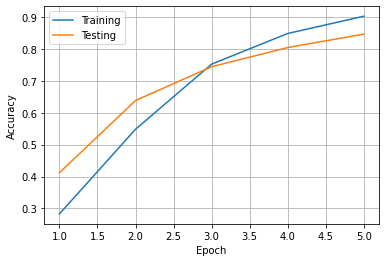

In [13]:
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")

In [91]:
class SGD_EnKF(Optimizer):
  """Stochastic gradient descent optimizer.

  Includes support for momentum,
  learning rate decay, and Nesterov momentum.

  Arguments:
      lr: float >= 0. Learning rate.
      momentum: float >= 0. Parameter that accelerates SGD in the relevant
        direction and dampens oscillations.
      decay: float >= 0. Learning rate decay over each update.
      nesterov: boolean. Whether to apply Nesterov momentum.
  """

  def __init__(self, num_particles = 2, h_0 = 2, **kwargs):
    super(SGD_EnKF, self).__init__(**kwargs) # für alle Optimizer gleich, SGD vom Namen der Klasse
    with K.name_scope(self.__class__.__name__): # Prefix self.__class__.__name__
      self.iterations = K.variable(0, dtype='int64', name='iterations')
      self.h_0 = K.variable(h_0, dtype = "float32", name = "h_0") 
      self.num_particles = num_particles
 
  def _create_all_weights(self, params): # Gewichte mit der richtigen Shape
    shapes = [K.int_shape(p) for p in params]
    moments = [K.zeros(shape) for shape in shapes]
    self.weights = [self.iterations] + moments
    return moments

  def get_updates(self, loss, params): 
    gradients = list(np.zeros(self.num_particles))
    print(gradients)
    print(self.num_particles)
    for particle in range(self.num_particles):
        print("ja")
        gradients[particle] = self.get_gradients(loss, params)
    #print(gradients)
    for i in range(len(gradients[0])):
        grad_index_i = 1
        for j in range(self.num_particles):
            print("")
    test = [gradients[0][0], gradients[1][0]]
    print(test)
    print("-----------------------")
    print(tf.math.reduce_mean(test))
    grads = self.get_gradients(loss, params)
    self.updates = [state_ops.assign_add(self.iterations, 1)] # das immer

    h_0 = self.h_0
    
    # momentum
    moments = self._create_all_weights(params)
    for p, g, m in zip(params, grads, moments):
      v = m - h_0 * g  # velocity    # Gradient Descent Updates
      self.updates.append(state_ops.assign(m, v))  # das immer
        
      new_p = p + v

      # Apply constraints.
      if getattr(p, 'constraint', None) is not None:
        new_p = p.constraint(new_p)

      self.updates.append(state_ops.assign(p, new_p))    # das immer
    return self.updates

  def get_config(self):      # das immer auf diese Art
    config = {
        "h_0": float(K.get_value(self.h_0)),
    }
    base_config = super(SGD_EnKF, self).get_config()     # das immer
    return dict(list(base_config.items()) + list(config.items()))  # das immer

[0.0, 0.0]
2
ja
ja




















[<tf.Tensor 'training/gradients/dense/MatMul_grad/MatMul_1:0' shape=(784, 128) dtype=float32>, <tf.Tensor 'training/gradients_1/dense/MatMul_grad/MatMul_1:0' shape=(784, 128) dtype=float32>]
-----------------------
Tensor("training/Mean:0", shape=(), dtype=float32)
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 0s 174us/sample - loss: nan - accuracy: 0.1140 - val_loss: nan - val_accuracy: 0.1120
Epoch 2/5
1000/1000 [==============================] - 0s 152us/sample - loss: nan - accuracy: 0.1110 - val_loss: nan - val_accuracy: 0.1120
Epoch 3/5
1000/1000 [==============================] - 0s 165us/sample - loss: nan - accuracy: 0.1110 - val_loss: nan - val_accuracy: 0.1120
Epoch 4/5
1000/1000 [==============================] - 0s 145us/sample - loss: nan - accuracy: 0.1110 - val_loss: nan - val_accuracy: 0.1120
Epoch 5/5
1000/1000 [==============================] - 0s 209us/sample - loss: nan -

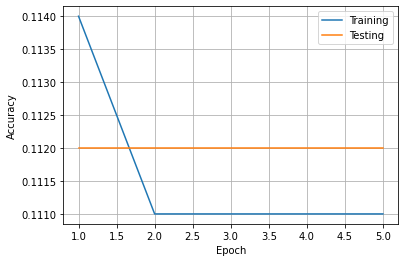

In [92]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model,
                        optimizer = SGD_EnKF())
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 10,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")

In [38]:
model.output[0]

<tf.Tensor 'strided_slice:0' shape=(10,) dtype=float32>

In [45]:
class COCOB(Optimizer):
    """Coin Betting Optimizer from the paper:
        https://arxiv.org/pdf/1705.07795.pdf
    """
    def __init__(self, alpha=100, **kwargs):
        """
        Initialize COCOB Optimizer
        Args:
            alpha: Refer to paper.
        """
        super(COCOB, self).__init__(**kwargs)
        self._alpha = alpha
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            
    def get_updates(self, params, loss, contraints=None):
        
        self.updates = [K.update_add(self.iterations, 1)]
        grads = self.get_gradients(loss, params)
        shapes = [K.int_shape(p) for p in params]
        L = [K.variable(np.full(fill_value=1e-8, shape=shape)) for shape in shapes]
        reward = [K.zeros(shape) for shape in shapes]
        tilde_w = [K.zeros(shape) for shape in shapes]
        gradients_sum = [K.zeros(shape) for shape in shapes]
        gradients_norm_sum = [K.zeros(shape) for shape in shapes]
        
        for p, g, li, ri, twi, gsi, gns in zip(params, grads, L, reward,
                                             tilde_w,gradients_sum,
                                               gradients_norm_sum):
            grad_sum_update = gsi + g
            grad_norm_sum_update = gns + K.abs(g)
            l_update = K.maximum(li, K.abs(g))
            reward_update = K.maximum(ri - g * twi, 0)
            new_w = - grad_sum_update / (l_update * (K.maximum(grad_norm_sum_update + l_update, self._alpha * l_update))) * (reward_update + l_update)
            param_update = p - twi + new_w
            tilde_w_update = new_w            
            
            self.updates.append(K.update(gsi, grad_sum_update))
            self.updates.append(K.update(gns, grad_norm_sum_update))
            self.updates.append(K.update(li, l_update))
            self.updates.append(K.update(ri, reward_update))
            self.updates.append(K.update(p, param_update))
            self.updates.append(K.update(twi, tilde_w_update))
            
            return self.updates
        
    def get_config(self):

        config = {'alpha': float(K.get_value(self._alpha)) }
        base_config = super(COCOB, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 1s 569us/sample - loss: 1.4419 - accuracy: 0.5480 - val_loss: 1.0290 - val_accuracy: 0.7200
Epoch 2/5
1000/1000 [==============================] - 1s 584us/sample - loss: 0.6516 - accuracy: 0.8170 - val_loss: 0.7731 - val_accuracy: 0.8240
Epoch 3/5
1000/1000 [==============================] - 1s 516us/sample - loss: 0.3688 - accuracy: 0.9210 - val_loss: 0.6527 - val_accuracy: 0.8320
Epoch 4/5
1000/1000 [==============================] - 0s 467us/sample - loss: 0.2216 - accuracy: 0.9680 - val_loss: 0.6057 - val_accuracy: 0.8420
Epoch 5/5
1000/1000 [==============================] - 0s 481us/sample - loss: 0.1518 - accuracy: 0.9800 - val_loss: 0.5833 - val_accuracy: 0.8440
Overall calculation took 3.528202533721924 seconds.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense) 

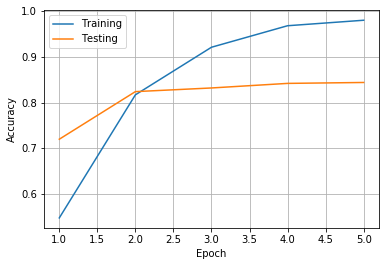

In [46]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model,
                        optimizer = COCOB())
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 10,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")